In [2]:
%matplotlib inline
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import copy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Copy paste från lab0
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        print(f"Device: {str(self.device).upper()}")

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm = True):
    accuracy = correct_predictions / total_predictions
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    auc = roc_auc_score(all_targets, [p[1] for p in all_probs])
        
    print(f"\rAccuracy  : {accuracy*100:.2f}%")
    print(f"Precision : {precision*100:.2f}%")
    print(f"Recall    : {recall*100:.2f}%")
    print(f"F1 Score  : {f1*100:.2f}%")
    print(f"AUC Score : {auc*100:.2f}%")
    if display_cm:
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

In [5]:
def train_and_validate(nn, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler = None, print_seperate = False, patience=5) -> None:
    """
    Train and validate a neural network model with early stopping.

    Parameters:
    - nn : torch.nn.Module
        The neural network model to train and validate.
    - train_loader : DataLoader
        The DataLoader containing the training dataset.
    - val_loader : DataLoader
        The DataLoader containing the validation dataset.
    - criterion : torch.nn.Module
        The loss function to use.
    - optimizer : torch.optim.Optimizer
        The optimizer to use.
    - num_epochs : int
        The number of epochs to train the model.
    - patience : int
        The number of epochs to wait for improvement in validation loss before stopping.
    """

    nn.to(nn.device)

    n = int(len(str(abs(num_epochs))))
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        nn.train()
        total_train_loss = 0

        ind = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)

            optimizer.zero_grad()
            outputs = nn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            total_train_loss += loss.item()
            print(f"\rTraining.. Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(train_loader)})", end="")
            ind += 1

        nn.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            ind = 0
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(nn.device), labels.to(nn.device)

                outputs = nn(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                print(f"\rValidating Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(val_loader):>3})", end="")
                ind += 1



                    
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions
        
        if scheduler:
            # reducelr... vill tydligen ha lossen exlipcitly 
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        print(f'\r.......... Epoch [{epoch+1:>n}/{num_epochs:>n}], ({len(val_loader):>3}/{len(val_loader):>3}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%', end="")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f" Early stopping: {epochs_no_improve}/{patience}", end="")
            if epochs_no_improve >= patience:
                print(f"\nNo improvement in {epochs_no_improve} epochs, stopping early.")
                break
        # Early stopping 
        if print_seperate:
            print()
    print()

        


def test_model(nn, test_loader, display_cm = True) -> None:
    """
    Test a neural network model on a given dataset.

    Parameters:
    - model : torch.nn.Module
        The trained neural network model to test.
    - test_loader : DataLoader
        The DataLoader for the test dataset.
    """


    print("\rTesting...", end = "")
    nn.to(nn.device)
    nn.eval()
    
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    all_probs = []


    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)
            outputs = nn(inputs)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # För F1, Rec, Pre, AUC:
            probs = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    # Compute evalulation metrics
    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm)



In [6]:

def ensemble_prediction(models: list[torch.nn.Module], inputs: torch.Tensor, scheme: str = "Majority Vote"):
    device = models[0].device
    for model in models:
        model.eval()
        model.to(device)

    # Averagar modellernas output, vi borde testa typ weighted averaging och eller boosting
    #with torch.no_grad():
    #    outputs = sum(model(inputs) for model in models) / len(models)
    #    return outputs
    with torch.no_grad():
        match scheme: 
            case "Majority Vote":
                pass
            case "Average":
                pass
            case "Weighted Average":
                pass
            case "Soft Voting":
                pass




def test_ensemble(models: list[torch.nn.Module], test_loader: DataLoader, scheme: str = "Majority Vote",  display_cm: bool = True):
    print(f"Scheme: {scheme}")
    device = models[0].device
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ensemble_prediction(models, inputs, scheme)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # För F1, Rec, Pre, AUC:
            probs = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm)
    

In [7]:
#local_directory = "C:/Users/hampu/Documents/kurser/år3/d7047e/images"
local_directory = "C:/Users/hampek/Documents/school/d7047e/images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4815], std=[0.2221]) # <-- beräknat med compute_mean_std() mean=[0.4815], std=[0.2221]
])

full_dataset = ImageFolder(root=local_directory, transform=transform)

# 70/15/15 split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,  num_workers = num_workers)
val_loader   = DataLoader(val_dataset,   batch_size = batch_size, shuffle=False, num_workers = num_workers)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle=False, num_workers = num_workers)



In [8]:
def compute_mean_std(): 
    # tar fram mean och std för hela datasettet, till transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    data = ImageFolder(root=local_directory, transform=transform)

    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

    mean = 0
    std = 0
    total_samples = 0
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    print("Mean:", mean)
    print("Std:", std)

Device: CPU
.......... Epoch [1/100], ( 28/ 28), Train Loss: 0.3557, Val Loss: 0.1931, Accuracy: 92.94%
.......... Epoch [2/100], ( 28/ 28), Train Loss: 0.1398, Val Loss: 0.1434, Accuracy: 95.22%
.......... Epoch [3/100], ( 28/ 28), Train Loss: 0.1126, Val Loss: 0.1399, Accuracy: 94.19%
.......... Epoch [4/100], ( 28/ 28), Train Loss: 0.1004, Val Loss: 0.1255, Accuracy: 95.44%
.......... Epoch [5/100], ( 28/ 28), Train Loss: 0.0821, Val Loss: 0.1447, Accuracy: 94.65% Early stopping: 1/5
.......... Epoch [6/100], ( 28/ 28), Train Loss: 0.0720, Val Loss: 0.1680, Accuracy: 94.99% Early stopping: 2/5
.......... Epoch [7/100], ( 28/ 28), Train Loss: 0.0481, Val Loss: 0.1506, Accuracy: 94.53% Early stopping: 3/5
.......... Epoch [8/100], ( 28/ 28), Train Loss: 0.0356, Val Loss: 0.1402, Accuracy: 95.44% Early stopping: 4/5
.......... Epoch [9/100], ( 28/ 28), Train Loss: 0.0329, Val Loss: 0.1419, Accuracy: 95.44% Early stopping: 5/5
No improvement in 5 epochs, stopping early.

Accuracy  : 95.

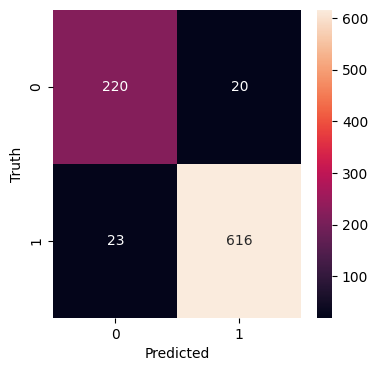

In [11]:
model = CNN()
num_epochs = 100
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate=True)
test_model(model, test_loader)



#med 0.001 learning rate efter 4 epochs lmao (9 - 5 early stop)
#Accuracy  : 93.29%
#Precision : 93.39%
#Recall    : 93.29%
#F1 Score  : 93.13%
#AUC Score : 97.76% 

In [1]:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630

resnet    = models.resnet18(pretrained=True)
googlenet = models.googlenet(pretrained=True)
densenet  = models.densenet121(pretrained=True)

num_epochs = 30
learning_rate = 0.0001
criterion = torch.nn.CrossEntropyLoss()

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.device    = _device
googlenet.device = _device
densenet.device  = _device

resnet.fc           = torch.nn.Linear(resnet.fc.in_features, 2)
googlenet.fc        = torch.nn.Linear(googlenet.fc.in_features, 2)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, 2)

optimizer_resnet    = torch.optim.Adam(resnet.parameters(), lr=learning_rate)
optimizer_googlenet = torch.optim.Adam(googlenet.parameters(), lr=learning_rate)
optimizer_densenet  = torch.optim.Adam(densenet.parameters(), lr=learning_rate)

scheduler_resnet    = ReduceLROnPlateau(optimizer_resnet)
scheduler_googlenet = ReduceLROnPlateau(optimizer_googlenet)
scheduler_densenet  = ReduceLROnPlateau(optimizer_densenet)

NameError: name 'models' is not defined

In [ ]:
zipped = zip([resnet, googlenet, densenet],
    [optimizer_resnet, optimizer_googlenet, optimizer_densenet],
    [scheduler_resnet, scheduler_googlenet, scheduler_densenet])

for model, optimizer, scheduler in zipped:
    print(f"Network: {model.__class__.__name__}")
    train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, print_seperate=True)
    test_model(model, test_loader, display_cm = False)


In [ ]:
print("Ensemble test:")
#"Majority Vote","Average","Weighted Average","Soft Voting":
test_ensemble([resnet, googlenet, densenet], test_loader, scheme = "Majority Vote", display_cm = True)







